In [ ]:
import pandas as pd
import tensorflow as tf
import sys
mod = sys.modules[__name__]
import matplotlib.pyplot as plt
from functools import partial
%matplotlib inline

Data = pd.concat([pd.read_csv(r'D:\Desktop\SynologyDrive\하강우\wedge_pr_t\Data\case2_KW1_wedge_trim.csv'),pd.read_csv(r'D:\Desktop\SynologyDrive\하강우\wedge_pr_t\Data\case3_KW1_wedge_trim.csv')])
Data = Data[['Pr','dp/dx','dp/dy','tke_diss','S12','Pr_t']]
print('Train Data :',Data.shape)

Data1 = pd.read_csv(r'D:\Desktop\SynologyDrive\하강우\wedge_pr_t\Data\case1_KW1_wedge_trim.csv')
Data1 = Data1[['Pr','dp/dx','dp/dy','tke_diss','S12','Pr_t']]
print('Test Data :',Data1.shape)

def stz(Data):
    return (Data - Data.mean())/Data.std()

def norm(Data, min_norm=10, max_norm=20):
    return (Data - Data.min())/(Data.max() - Data.min())*(max_norm - min_norm) + min_norm

stz_Data = stz(Data)
norm_Data = norm(stz_Data)

stz_Data1 = (Data1 - Data.mean())/Data.std()
norm_Data1 = (stz_Data1 - stz_Data.min())/(stz_Data.max() - stz_Data.min())*(20 - 10) + 10

In [ ]:
num_output = 1
num_layer = 14
num_neuron = 80
activation_function = 'tanh'
# initializer = tf.keras.initializers.RandomUniform(minval=-1, maxval=1)
initializer = tf.keras.initializers.he_normal()
optimizer = 'RMSProp'
overfitting_step = 200

num_epochs = 100000
batch_size = 256
print_step = 100

dense_layer = partial(tf.layers.dense, activation=None, kernel_initializer=initializer, use_bias=True, bias_initializer=initializer)

X = tf.placeholder(tf.float32, shape=[None, 5])
Y = tf.placeholder(tf.float32, shape=[None, 1])

for i in range(num_layer):
    if i == 0:
        setattr(mod, 'hidden{}'.format(i+1),dense_layer(X,num_neuron))

    else:
        setattr(mod, 'hidden{}'.format(i+1),dense_layer(getattr(mod, 'hidden{}_act'.format(i)),num_neuron))
        
    setattr(mod,'hidden{}_act'.format(i+1),getattr(tf.nn,activation_function)(getattr(mod,'hidden{}'.format(i+1))))
    
model = dense_layer(getattr(mod,'hidden{}'.format(num_layer)), num_output)

mse_loss = tf.reduce_mean(tf.square(model - Y))

# train_op = tf.train.RMSPropOptimizer(0.000001).minimize(mse_loss)
train_op = tf.train.GradientDescentOptimizer(0.000001).minimize(mse_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

test_loss = 1000
num_overfit = 0
ttrain_loss = []
ttest_loss = []

for epoch in range(num_epochs):
    
    batch_X = norm_Data[norm_Data.columns[:-1]].sample(n=batch_size)
    batch_Y = norm_Data[norm_Data.columns[-1:]].iloc[batch_X.index]
    
    sess.run(train_op, feed_dict={X: batch_X, Y: batch_Y})
    
    if test_loss >= sess.run(mse_loss, feed_dict={X: norm_Data1[norm_Data.columns[:-1]], Y: norm_Data1[norm_Data.columns[-1:]]}):
        test_loss = sess.run(mse_loss, feed_dict={X: norm_Data1[norm_Data.columns[:-1]], Y: norm_Data1[norm_Data.columns[-1:]]})
        num_overfit = 0
        
    else:
        num_overfit += 1
        
    if num_overfit == overfitting_step:
        print('overfitting occurs !')
        break
        
    if(epoch+1)%print_step == 0:
        ttrain_loss.append(sess.run(mse_loss, feed_dict={X: norm_Data[norm_Data.columns[:-1]], Y: norm_Data[norm_Data.columns[-1:]]}))
        ttest_loss.append(sess.run(mse_loss, feed_dict={X: norm_Data1[norm_Data.columns[:-1]], Y: norm_Data1[norm_Data.columns[-1:]]}))
        print('Train : ',sess.run(mse_loss, feed_dict={X: norm_Data[norm_Data.columns[:-1]], Y: norm_Data[norm_Data.columns[-1:]]}))
        print('Test : ',sess.run(mse_loss, feed_dict={X: norm_Data1[norm_Data.columns[:-1]], Y: norm_Data1[norm_Data.columns[-1:]]}))

In [ ]:
TRAIN = pd.DataFrame()
TRAIN['model'] = sess.run(model, feed_dict={X: norm_Data[norm_Data.columns[:-1]]}).flatten()
TRAIN['y_data'] = norm_Data[norm_Data.columns[-1]].reset_index(drop=True)

TRAIN = (TRAIN - 1)/(2 - 1)*(stz_Data.max()[-1] - stz_Data.min()[-1]) + stz_Data.min()[-1]
TRAIN = TRAIN*Data.std()[-1] + Data.mean() [-1]

TEST = pd.DataFrame()
TEST['model'] = sess.run(model, feed_dict={X: norm_Data1[norm_Data.columns[:-1]]}).flatten()
TEST['y_data'] = norm_Data[norm_Data1.columns[-1]].reset_index(drop=True)

TEST = (TEST - 1)/(2 - 1)*(stz_Data.max()[-1] - stz_Data.min()[-1]) + stz_Data.min()[-1]
TEST = TEST*Data.std()[-1] + Data.mean() [-1]

plt.scatter(TRAIN['model'], TRAIN['y_data'],s=1)
plt.scatter(TEST['model'], TEST['y_data'],s=1)
plt.axis([0,3,0,3])

In [ ]:
import numpy as np
print(np.sqrt(((TRAIN['model'] - TRAIN['y_data'])**2).mean()))
print(np.sqrt(((TEST['model'] - TEST['y_data'])**2).mean()))

In [ ]:
plt.scatter(sess.run(model, feed_dict={X: norm_Data[norm_Data.columns[:-1]]}),norm_Data[norm_Data.columns[-1:]], s=1,color='b' )
plt.scatter(sess.run(model, feed_dict={X: norm_Data1[norm_Data1.columns[:-1]]}),norm_Data1[norm_Data1.columns[-1:]], s=1,color='orange' )
plt.axis([1,2,1,2])
plt.grid(True)

In [ ]:
aa = [print_step*i for i in range(len(ttrain_loss))]
plt.plot(aa,ttrain_loss,label='train')
plt.plot(aa,ttest_loss,label='test')
plt.axis([-100,5000,0,0.1])
plt.legend()

In [ ]:
# train_op = tf.train.RMSPropOptimizer(0.000001).minimize(mse_loss)
num_overfit = 0
for epoch in range(num_epochs):
    
    batch_X = norm_Data[norm_Data.columns[:-1]].sample(n=batch_size)
    batch_Y = norm_Data[norm_Data.columns[-1:]].iloc[batch_X.index]
    
    sess.run(train_op, feed_dict={X: batch_X, Y: batch_Y})
    
    if test_loss >= sess.run(mse_loss, feed_dict={X: norm_Data1[norm_Data.columns[:-1]], Y: norm_Data1[norm_Data.columns[-1:]]}):
        test_loss = sess.run(mse_loss, feed_dict={X: norm_Data1[norm_Data.columns[:-1]], Y: norm_Data1[norm_Data.columns[-1:]]})
        num_overfit = 0
        
    else:
        num_overfit += 1
        
#     if num_overfit == overfitting_step:
    if num_overfit == 1000:
        print('overfitting occurs !')
        break
        
    if(epoch+1)%print_step == 0:
        ttrain_loss.append(sess.run(mse_loss, feed_dict={X: norm_Data[norm_Data.columns[:-1]], Y: norm_Data[norm_Data.columns[-1:]]}))
        ttest_loss.append(sess.run(mse_loss, feed_dict={X: norm_Data1[norm_Data.columns[:-1]], Y: norm_Data1[norm_Data.columns[-1:]]}))
        print('Train : ',sess.run(mse_loss, feed_dict={X: norm_Data[norm_Data.columns[:-1]], Y: norm_Data[norm_Data.columns[-1:]]}))
        print('Test : ',sess.run(mse_loss, feed_dict={X: norm_Data1[norm_Data.columns[:-1]], Y: norm_Data1[norm_Data.columns[-1:]]}))

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sys
mod = sys.modules[__name__]

Data = pd.read_csv(r'D:\Desktop\SynologyDrive\하강우\bubble\data\bubble.csv')
R = pd.read_csv(r'D:\Desktop\SynologyDrive\하강우\bubble\data\R.csv')

case_list = [[0,5],[5,20],[20,35],[35,50],[50,65],[65,80],[80,95],[95,110],[110,125],[125,140],
             [140,155],[155,162],[162,169],[169,176],[176,183],[183,198],[198,213],[213,228],
             [228,243],[243,258],[258,273],[273,288],[288,302]]
for j in range(5):
    for i in range(len(case_list)):
        setattr(mod,'case{}_Data'.format(i+1),pd.read_csv(r'D:\Desktop\SynologyDrive\하강우\bubble\regular_ANN\iterfix_case{}_Data_{}.csv'.format(i+1,j+1)))
        setattr(mod,'case{}_data'.format(i+1),getattr(mod,'case{}_Data'.format(i+1))*Data.std()[-1] + Data.mean()[-1])
        getattr(mod,'case{}_data'.format(i+1))['model'] = getattr(mod,'case{}_data'.format(i+1))['model']*R['R']
        getattr(mod,'case{}_data'.format(i+1))['y_data'] = getattr(mod,'case{}_data'.format(i+1))['y_data']*R['R']

        setattr(mod,'inter_case{}_Data'.format(i+1),getattr(mod,'case{}_data'.format(i+1)).drop(range(case_list[i][0],case_list[i][1])))
        setattr(mod,'extra_case{}_Data_{}'.format(i+1,j+1),getattr(mod,'case{}_data'.format(i+1)).iloc[case_list[i][0]:case_list[i][1]])


In [2]:
# plt.scatter((case1_Data*Data.std()[-1] + Data.mean()[-1])['model']*R['R'],(case1_Data*Data.std()[-1] + Data.mean()[-1])['y_data']*R['R'])
case1_data

,model,y_data
0,2.700739,3.5498
1,2.700739,3.5498
2,2.624547,3.6405
3,2.574566,3.6949
4,2.327320,3.7311
5,4.196131,3.7930
6,3.185477,3.7807
7,4.298637,3.7198
8,4.293939,3.7439
9,4.227503,3.7154


In [2]:
def RMSE(A,B):
    """
    A,B : Pandas Series type
    A : model
    B : true
    """
    return np.sqrt(((A - B)**2).mean())

def ARE(A,B):
    """
    A,B : Pandas Series type
    A : model
    B : true
    """
    return (abs((A - B)/B)*100).mean()

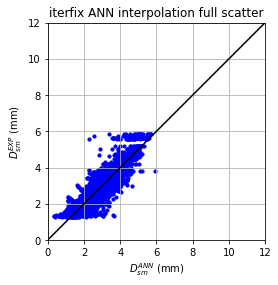

In [92]:
#inter full scatter
plt.gca().set_aspect("equal")
for i in range(len(case_list)):
    plt.scatter(getattr(mod,'inter_case{}_Data'.format(i+1))['model'],getattr(mod,'inter_case{}_Data'.format(i+1))['y_data'],s=10,color='b')
plt.axis([0,12,0,12])
plt.plot([0,12],[0,12],color='k')
plt.xlabel('$D_{sm}^{ANN}$ (mm)')
plt.ylabel('$D_{sm}^{EXP}$ (mm)')
plt.title('iterfix ANN interpolation full scatter')
plt.grid(True)
plt.savefig(r'D:\Desktop\SynologyDrive\하강우\bubble\regular_ANN\regular_ANN_iterfix_inter_Full_scatter.png',dpi=300)

In [31]:
aa = []
bb = []
for i in range(len(case_list)):
    aa.append(RMSE(getattr(mod,'inter_case{}_Data'.format(i+1))['model'],getattr(mod,'inter_case{}_Data'.format(i+1))['y_data']))
    bb.append(ARE(getattr(mod,'inter_case{}_Data'.format(i+1))['model'],getattr(mod,'inter_case{}_Data'.format(i+1))['y_data']))
print(sum(aa)/len(aa))
print(sum(bb)/len(bb))

0.3835693631774453
10.62971926576455


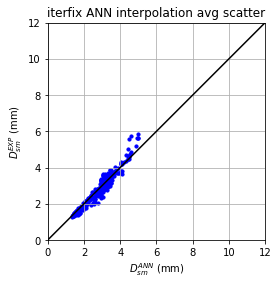

In [4]:
import numpy as np

avg_inter_model = pd.DataFrame()
avg_inter_y_data = pd.DataFrame()

for i in range(len(case_list)):
    avg_inter_model['model{}'.format(i+1)] = getattr(mod,'inter_case{}_Data'.format(i+1))['model']
    avg_inter_y_data['y_data{}'.format(i+1)] = getattr(mod,'inter_case{}_Data'.format(i+1))['y_data']

plt.gca().set_aspect("equal")
plt.scatter((avg_inter_model.sum(axis=1,skipna=True))/(len(case_list)-1),(avg_inter_y_data.sum(axis=1,skipna=True))/(len(case_list)-1),s=10,color='b')
plt.axis([0,12,0,12])
plt.plot([0,12],[0,12],color='k')
plt.xlabel('$D_{sm}^{ANN}$ (mm)')
plt.ylabel('$D_{sm}^{EXP}$ (mm)')
plt.title('iterfix ANN interpolation avg scatter')
plt.grid(True)
# plt.savefig(r'D:\Desktop\SynologyDrive\하강우\bubble\regular_ANN\regular_ANN_iterfix_inter_avg_scatter.png',dpi=300)

In [32]:
print(RMSE((avg_inter_model.sum(axis=1,skipna=True))/(len(case_list)-1),(avg_inter_y_data.sum(axis=1,skipna=True))/(len(case_list)-1)))
print(ARE((avg_inter_model.sum(axis=1,skipna=True))/(len(case_list)-1),(avg_inter_y_data.sum(axis=1,skipna=True))/(len(case_list)-1)))

0.26253168098803725
6.764876400150205


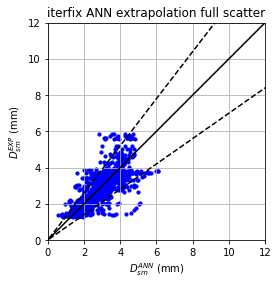

In [95]:
#inter full scatter
plt.gca().set_aspect("equal")
for j in range(5):
    for i in range(len(case_list)):
        plt.scatter(getattr(mod,'extra_case{}_Data_{}'.format(i+1,j+1))['model'],getattr(mod,'extra_case{}_Data_{}'.format(i+1,j+1))['y_data'],s=10,color='b')
plt.axis([0,12,0,12])
plt.plot([0,12],[0,12],color='k')
plt.plot(x,y1,'--',color='k')
plt.plot(x,y2,'--',color='k')
plt.xlabel('$D_{sm}^{ANN}$ (mm)')
plt.ylabel('$D_{sm}^{EXP}$ (mm)')
plt.title('iterfix ANN extrapolation full scatter')
plt.grid(True)
plt.savefig(r'D:\Desktop\SynologyDrive\하강우\bubble\regular_ANN\regular_ANN_iterfix_extra_Full_scatter.png',dpi=300)

In [34]:
aa = []
bb = []
for i in range(len(case_list)):
    aa.append(RMSE(getattr(mod,'extra_case{}_Data_{}'.format(i+1,j+1))['model'],getattr(mod,'extra_case{}_Data_{}'.format(i+1,j+1))['y_data']))
    bb.append(ARE(getattr(mod,'extra_case{}_Data_{}'.format(i+1,j+1))['model'],getattr(mod,'extra_case{}_Data_{}'.format(i+1,j+1))['y_data']))
    
print(sum(aa)/len(aa))
print(sum(bb)/len(bb))

0.550491277147081
17.539219772634993


In [17]:
for j in range(5):
    setattr(mod,'extra_model_{}'.format(j+1),pd.DataFrame())  
    for i in range(len(case_list)):
        setattr(mod,'extra_model_{}'.format(j+1),getattr(mod,'extra_model_{}'.format(j+1)).append(getattr(mod,'extra_case{}_Data_{}'.format(i+1,j+1))))

,model,y_data
0,3.036785,3.5498
1,3.036785,3.5498
2,2.991016,3.6405
3,2.954440,3.6949
4,2.770764,3.7311
5,5.960730,3.7930
6,6.093641,3.7807
7,5.549817,3.7198
8,5.498070,3.7439
9,5.140555,3.7154


In [18]:
RA_extra = pd.DataFrame()
RA_extra['model'] = [i for i in range(len(extra_model_1))]
for j in range(5):
    RA_extra['model{}'.format(j+1)] = getattr(mod,'extra_model_{}'.format(j+1))['model']
    
del RA_extra['model']
RA_extra.head()

,model1,model2,model3,model4,model5
0,3.036785,3.080385,3.024695,2.968883,2.700739
1,3.036785,3.080385,3.024695,2.968883,2.700739
2,2.991016,3.012064,3.099377,2.946421,2.624547
3,2.954440,2.959716,3.149848,2.935318,2.574566
4,2.770764,2.668269,3.365594,2.916557,2.327320


In [19]:
avg_RA_extra = RA_extra.mean(axis=1)
std_RA_extra = RA_extra.std(axis=1)

RA_extra_csv = pd.DataFrame()
RA_extra_csv['avg'] = avg_RA_extra
RA_extra_csv['std'] = std_RA_extra
RA_extra_csv.to_csv(r'D:\Desktop\SynologyDrive\하강우\bubble\wallcoresnu\RA_extra_avg_std.csv',header=True,index=False)

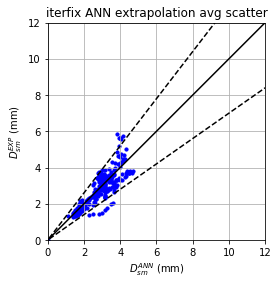

In [4]:
import numpy as np
x = np.linspace(-1,12)
y1 = x*1.3
y2 = x*0.7

avg_extra_model = pd.DataFrame()
avg_extra_y_data = pd.DataFrame()
avg_extra_model['model'] = [0 for i in range(len(Data))]
avg_extra_y_data['y_data'] = [0 for i in range(len(Data))]

for j in range(5):
    for i in range(len(case_list)):
        avg_extra_model['model{}_{}'.format(i+1,j+1)] = getattr(mod,'extra_case{}_Data_{}'.format(i+1,j+1))['model']
        avg_extra_y_data['y_data{}_{}'.format(i+1,j+1)] = getattr(mod,'extra_case{}_Data_{}'.format(i+1,j+1))['y_data']

plt.gca().set_aspect("equal")
plt.scatter((avg_extra_model.sum(axis=1,skipna=True))/5,(avg_extra_y_data.sum(axis=1,skipna=True))/5,s=10,color='b')
plt.plot(x,y1,'--',color='k')
plt.plot(x,y2,'--',color='k')
plt.axis([0,12,0,12])
plt.plot([0,12],[0,12],color='k')
plt.xlabel('$D_{sm}^{ANN}$ (mm)')
plt.ylabel('$D_{sm}^{EXP}$ (mm)')
plt.title('iterfix ANN extrapolation avg scatter')
plt.grid(True)
# plt.savefig(r'D:\Desktop\SynologyDrive\하강우\bubble\regular_ANN\regular_ANN_iterfix_extra_avg_scatter.png',dpi=300)

In [6]:
avg_extra_model

,model,model1_1,model2_1,model3_1,model4_1,model5_1,model6_1,model7_1,model8_1,model9_1,...,model14_5,model15_5,model16_5,model17_5,model18_5,model19_5,model20_5,model21_5,model22_5,model23_5
0,0,3.036785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,3.036785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2.991016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2.954440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2.770764,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,NaN,5.960730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,NaN,6.093641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0,NaN,5.549817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,NaN,5.498070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,NaN,5.140555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print(RMSE((avg_extra_model.sum(axis=1,skipna=True))/5,(avg_extra_y_data.sum(axis=1,skipna=True))/5))
print(ARE((avg_extra_model.sum(axis=1,skipna=True))/5,(avg_extra_y_data.sum(axis=1,skipna=True))/5))

0.5270293194546537
13.322298161908723


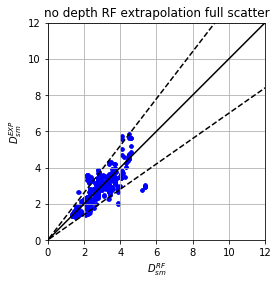

In [46]:
plt.gca().set_aspect("equal")
for i in range(3):
    plt.scatter(getattr(mod,'RF_extra_{}'.format(i+1))['model'],getattr(mod,'RF_extra_{}'.format(i+1))['y_data'],s=10,color='b')
plt.plot([0,12],[0,12],color='k')
plt.plot(x,y1,'--',color='k')
plt.plot(x,y2,'--',color='k')
plt.axis([0,12,0,12])
plt.grid(True)
plt.xlabel('$D_{sm}^{RF}$ (mm)')
plt.ylabel('$D_{sm}^{EXP}$ (mm)')
plt.title('no depth RF extrapolation full scatter')
plt.savefig(r'D:\Desktop\SynologyDrive\하강우\bubble\wallcoresnu\no_depth_RF_extra_full_scatter.png',dpi=300)

In [44]:
print(RMSE(RF_avg_extra['model'],RF_avg_extra['y_data']))
print(ARE(RF_avg_extra['model'],RF_avg_extra['y_data']))

0.6145879663796032
15.528289725555792


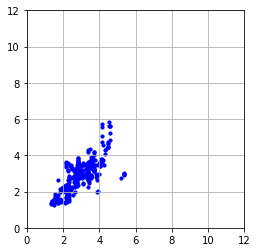

In [38]:
RF_avg_extra = 0
for i in range(3):
    setattr(mod,'RF_extra_{}'.format(i+1),pd.read_csv(r'D:\Desktop\SynologyDrive\하강우\bubble\wallcoresnu\RF_extra_{}.csv'.format(i+1)))
    RF_avg_extra += getattr(mod,'RF_extra_{}'.format(i+1))
    
    
RF_avg_extra = RF_avg_extra/3
plt.gca().set_aspect("equal")
plt.scatter(RF_avg_extra['model'],RF_avg_extra['y_data'],s=10,color='b')
plt.axis([0,12,0,12])
plt.grid(True)

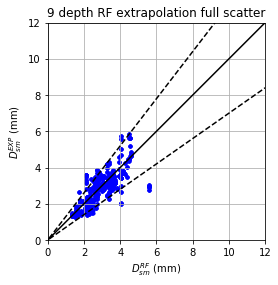

In [99]:
plt.gca().set_aspect("equal")
for i in range(3):
    plt.scatter(getattr(mod,'depth_RF_extra_{}'.format(i+1))['model'],getattr(mod,'depth_RF_extra_{}'.format(i+1))['y_data'],s=10,color='b')
plt.plot([0,12],[0,12],color='k')
plt.plot(x,y1,'--',color='k')
plt.plot(x,y2,'--',color='k')
plt.axis([0,12,0,12])
plt.grid(True)
plt.xlabel('$D_{sm}^{RF}$ (mm)')
plt.ylabel('$D_{sm}^{EXP}$ (mm)')
plt.title('9 depth RF extrapolation full scatter')
plt.savefig(r'D:\Desktop\SynologyDrive\하강우\bubble\wallcoresnu\9depth_3msl_RF_full_extra_scatter.png',dpi=300)

In [101]:
aa = []
bb = []
for i in range(3):
    aa.append(RMSE(getattr(mod,'depth_RF_extra_{}'.format(i+1))['model'],getattr(mod,'depth_RF_extra_{}'.format(i+1))['y_data']))
    bb.append(ARE(getattr(mod,'depth_RF_extra_{}'.format(i+1))['model'],getattr(mod,'depth_RF_extra_{}'.format(i+1))['y_data']))

print(sum(aa)/len(aa))
print(sum(bb)/len(bb))

0.654164622424044
16.47145340906698


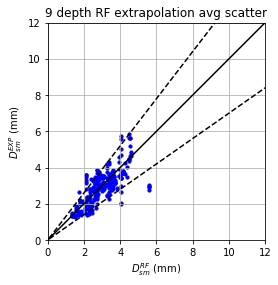

In [100]:
depth_RF_avg_extra = 0
for i in range(3):
    setattr(mod,'depth_RF_extra_{}'.format(i+1),pd.read_csv(r'D:\Desktop\SynologyDrive\하강우\bubble\wallcoresnu\9depth_3msl_RF_extra_{}.csv'.format(i+1)))
    depth_RF_avg_extra += getattr(mod,'depth_RF_extra_{}'.format(i+1))
    
depth_RF_avg_extra = depth_RF_avg_extra/3
plt.gca().set_aspect("equal")
plt.scatter(depth_RF_avg_extra['model'],depth_RF_avg_extra['y_data'],s=10,color='b')
plt.plot([0,12],[0,12],color='k')
plt.plot(x,y1,'--',color='k')
plt.plot(x,y2,'--',color='k')
plt.axis([0,12,0,12])
plt.grid(True)
plt.xlabel('$D_{sm}^{RF}$ (mm)')
plt.ylabel('$D_{sm}^{EXP}$ (mm)')
plt.title('9 depth RF extrapolation avg scatter')
plt.savefig(r'D:\Desktop\SynologyDrive\하강우\bubble\wallcoresnu\9depth_3msl_RF_avg_extra_scatter.png',dpi=300)

In [102]:
print(RMSE(depth_RF_avg_extra['model'],depth_RF_avg_extra['y_data']))
print(ARE(depth_RF_avg_extra['model'],depth_RF_avg_extra['y_data']))

0.6541534436560883
16.470272326948294


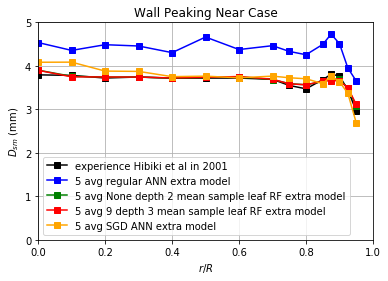

In [83]:
regular_5avg_extra = pd.DataFrame()
regular_5avg_extra['model'] = (avg_extra_model.sum(axis=1,skipna=True))/5
regular_5avg_extra['y_data'] = (avg_extra_y_data.sum(axis=1,skipna=True))/5

r_R = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.875,0.9,0.925,0.95]

plt.plot(r_R,regular_5avg_extra['y_data'].iloc[5:20],'s-',color='k',label='experience Hibiki et al in 2001')
plt.plot(r_R,regular_5avg_extra['model'].iloc[5:20],'s-',color='b',label='5 avg regular ANN extra model')
plt.plot(r_R,bb['model'].iloc[5:20],'s-',color='g',label='5 avg None depth 2 mean sample leaf RF extra model')
plt.plot(r_R,aa['model'].iloc[5:20],'s-',color='r',label='5 avg 9 depth 3 mean sample leaf RF extra model')
plt.plot(r_R,avg_SGD_ANN['model'].iloc[5:20],'s-',color='orange',label='5 avg SGD ANN extra model')
plt.axis([0,1,0,5])
plt.yticks([0,1,2,3,4,5])
plt.legend()
plt.grid(True)
plt.xlabel('$r/R$')
plt.ylabel('$D_{sm}$ (mm)')
plt.title('Wall Peaking Near Case')
plt.savefig(r'D:\Desktop\SynologyDrive\하강우\bubble\wallcoresnu\wall_core_exclude_snu_near_case_profile.png',dpi=300)

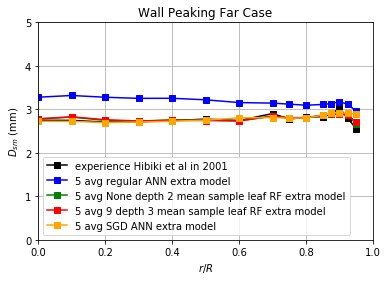

In [84]:
plt.plot(r_R,regular_5avg_extra['y_data'].iloc[35:50],'s-',color='k',label='experience Hibiki et al in 2001')
plt.plot(r_R,regular_5avg_extra['model'].iloc[35:50],'s-',color='b',label='5 avg regular ANN extra model')
plt.plot(r_R,bb['model'].iloc[35:50],'s-',color='g',label='5 avg None depth 2 mean sample leaf RF extra model')
plt.plot(r_R,aa['model'].iloc[35:50],'s-',color='r',label='5 avg 9 depth 3 mean sample leaf RF extra model')
plt.plot(r_R,avg_SGD_ANN['model'].iloc[35:50],'s-',color='orange',label='5 avg SGD ANN extra model')
plt.axis([0,1,0,5])
plt.yticks([0,1,2,3,4,5])
plt.legend()
plt.grid(True)
plt.xlabel('$r/R$')
plt.ylabel('$D_{sm}$ (mm)')
plt.title('Wall Peaking Far Case')
plt.savefig(r'D:\Desktop\SynologyDrive\하강우\bubble\wallcoresnu\wall_core_exclude_snu_far_case_profile.png',dpi=300)

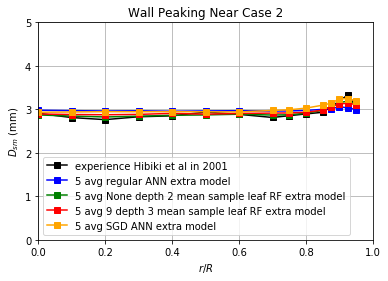

In [85]:
plt.plot(r_R,regular_5avg_extra['y_data'].iloc[110:125],'s-',color='k',label='experience Hibiki et al in 2001')
plt.plot(r_R,regular_5avg_extra['model'].iloc[110:125],'s-',color='b',label='5 avg regular ANN extra model')
plt.plot(r_R,bb['model'].iloc[110:125],'s-',color='g',label='5 avg None depth 2 mean sample leaf RF extra model')
plt.plot(r_R,aa['model'].iloc[110:125],'s-',color='r',label='5 avg 9 depth 3 mean sample leaf RF extra model')
plt.plot(r_R,avg_SGD_ANN['model'].iloc[110:125],'s-',color='orange',label='5 avg SGD ANN extra model')
plt.axis([0,1,0,5])
plt.yticks([0,1,2,3,4,5])
plt.legend()
plt.grid(True)
plt.xlabel('$r/R$')
plt.ylabel('$D_{sm}$ (mm)')
plt.title('Wall Peaking Near Case 2')
plt.savefig(r'D:\Desktop\SynologyDrive\하강우\bubble\wallcoresnu\wall_core_exclude_snu_near_case2_profile.png',dpi=300)

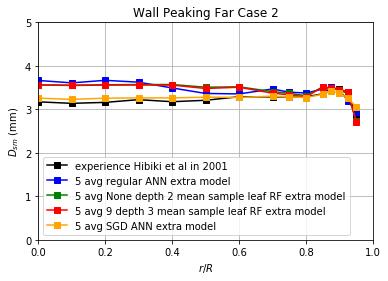

In [86]:
plt.plot(r_R,regular_5avg_extra['y_data'].iloc[20:35],'s-',color='k',label='experience Hibiki et al in 2001')
plt.plot(r_R,regular_5avg_extra['model'].iloc[20:35],'s-',color='b',label='5 avg regular ANN extra model')
plt.plot(r_R,bb['model'].iloc[20:35],'s-',color='g',label='5 avg None depth 2 mean sample leaf RF extra model')
plt.plot(r_R,aa['model'].iloc[20:35],'s-',color='r',label='5 avg 9 depth 3 mean sample leaf RF extra model')
plt.plot(r_R,avg_SGD_ANN['model'].iloc[20:35],'s-',color='orange',label='5 avg SGD ANN extra model')
plt.axis([0,1,0,5])
plt.yticks([0,1,2,3,4,5])
plt.legend()
plt.grid(True)
plt.xlabel('$r/R$')
plt.ylabel('$D_{sm}$ (mm)')
plt.title('Wall Peaking Far Case 2')
plt.savefig(r'D:\Desktop\SynologyDrive\하강우\bubble\wallcoresnu\wall_core_exclude_snu_far_case2_profile.png',dpi=300)

In [69]:
from sklearn import ensemble
import pandas as pd

Data = pd.read_csv(r'D:\Desktop\SynologyDrive\하강우\bubble\data\bubble.csv')
R_csv = pd.read_csv(r'D:\Desktop\SynologyDrive\하강우\bubble\data\R.csv')

def stz(Data):
    return (Data - Data.mean())/Data.std()

def norm(Data, min_norm=-0.9, max_norm=0.9):
    return (Data - Data.min())/(Data.max() - Data.min())*(max_norm - min_norm) + min_norm

stz_Data = stz(Data)
norm_Data = norm(Data)

All_Data = pd.DataFrame()
All_Data[Data.columns[0:3]] = norm_Data[Data.columns[0:3]]
All_Data[Data.columns[3]] = stz_Data[Data.columns[3]]
All_Data[Data.columns[4]] = norm_Data[Data.columns[4]]
All_Data[Data.columns[5]] = stz_Data[Data.columns[5]]
All_Data['R'] = R_csv[['R']].iloc[:len(Data)]

case_list = [[0,5],[5,20],[20,35],[35,50],[50,65],[65,80],[80,95],[95,110],[110,125],[125,140],
             [140,155],[155,162],[162,169],[169,176],[176,183],[183,198],[198,213],[213,228],
             [228,243],[243,258],[258,273],[273,288],[288,302]]

RF_model = ensemble.RandomForestRegressor(n_estimators=2000, min_samples_split=2, min_samples_leaf=3, bootstrap=True, oob_score=True, 
                                         max_depth=9, max_features='auto', random_state=Data.sample(n=1).index[0], n_jobs=2)
RF_model.fit(All_Data[All_Data.columns[:-2]].drop(range(case_list[2][0],case_list[2][1])),All_Data[All_Data.columns[-2:-1]].drop(range(case_list[2][0],case_list[2][1])))

aa = pd.DataFrame()
aa['model'] = RF_model.predict(All_Data[All_Data.columns[:-2]])
aa['y_data'] = All_Data[All_Data.columns[-2:-1]]

aa = aa*Data.std()[-1] + Data.mean()[-1]
aa['model'] = aa['model']*All_Data['R']
aa['y_data'] = aa['y_data']*All_Data['R']

c:\users\user\anaconda\envs\tensorflow4\lib\site-packages\ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [70]:
RF_model = ensemble.RandomForestRegressor(n_estimators=2000, min_samples_split=2, min_samples_leaf=2, bootstrap=True, oob_score=True, 
                                         max_depth=None, max_features='auto', random_state=Data.sample(n=1).index[0], n_jobs=2)
RF_model.fit(All_Data[All_Data.columns[:-2]].drop(range(case_list[2][0],case_list[2][1])),All_Data[All_Data.columns[-2:-1]].drop(range(case_list[2][0],case_list[2][1])))

bb = pd.DataFrame()
bb['model'] = RF_model.predict(All_Data[All_Data.columns[:-2]])
bb['y_data'] = All_Data[All_Data.columns[-2:-1]]

bb = bb*Data.std()[-1] + Data.mean()[-1]
bb['model'] = bb['model']*All_Data['R']
bb['y_data'] = bb['y_data']*All_Data['R']

c:\users\user\anaconda\envs\tensorflow4\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [54]:
avg_SGD_ANN = 0
for i in range(5):
    setattr(mod,'SGD_ANN_{}'.format(i+1),pd.read_csv(r'D:\Desktop\SynologyDrive\하강우\bubble\wallcoresnu\ANN_extra_{}.csv'.format(i+1)))
    avg_SGD_ANN += getattr(mod,'SGD_ANN_{}'.format(i+1))
avg_SGD_ANN = avg_SGD_ANN/5

In [87]:
print(RMSE(avg_SGD_ANN['model'],avg_SGD_ANN['y_data']))
print(ARE(avg_SGD_ANN['model'],avg_SGD_ANN['y_data']))

0.23274907016214355
5.747883147411678


In [91]:
aa = []
bb = []
for i in range(5):
    aa.append(RMSE(getattr(mod,'SGD_ANN_{}'.format(i+1))['model'],getattr(mod,'SGD_ANN_{}'.format(i+1))['y_data']))
    bb.append(ARE(getattr(mod,'SGD_ANN_{}'.format(i+1))['model'],getattr(mod,'SGD_ANN_{}'.format(i+1))['y_data']))
    
print(sum(aa)/len(aa))
print(sum(bb)/len(bb))

0.32959013053142855
7.386712900474815


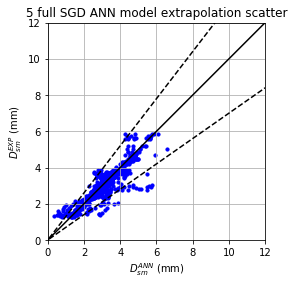

In [90]:
plt.gca().set_aspect("equal")
for i in range(5):
    plt.scatter(getattr(mod,'SGD_ANN_{}'.format(i+1))['model'],getattr(mod,'SGD_ANN_{}'.format(i+1))['y_data'],s=10,color='b')
plt.plot([0,12],[0,12],color='k')
plt.plot(x,y1,'--',color='k')
plt.plot(x,y2,'--',color='k')
plt.grid(True)
plt.axis([0,12,0,12])
plt.xlabel('$D_{sm}^{ANN}$ (mm)')
plt.ylabel('$D_{sm}^{EXP}$ (mm)')
plt.title('5 full SGD ANN model extrapolation scatter')
plt.savefig(r'D:\Desktop\SynologyDrive\하강우\bubble\wallcoresnu\5full_SGD_ANN_extra_scatter.png',dpi=300)

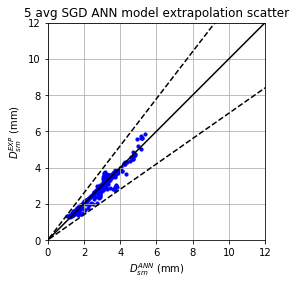

In [89]:
plt.gca().set_aspect("equal")
plt.scatter(avg_SGD_ANN['model'],avg_SGD_ANN['y_data'],s=10,color='b')
plt.plot([0,12],[0,12],color='k')
plt.plot(x,y1,'--',color='k')
plt.plot(x,y2,'--',color='k')
plt.grid(True)
plt.axis([0,12,0,12])
plt.xlabel('$D_{sm}^{ANN}$ (mm)')
plt.ylabel('$D_{sm}^{EXP}$ (mm)')
plt.title('5 avg SGD ANN model extrapolation scatter')
plt.savefig(r'D:\Desktop\SynologyDrive\하강우\bubble\wallcoresnu\5avg_SGD_ANN_extra_scatter.png',dpi=300)

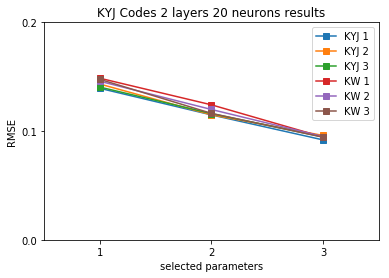

In [116]:
cc = [1, 2, 3]
dd = [0.13932, 0.114866, 0.091879]
plt.plot(cc,dd,'s-',label='KYJ 1')

plt.plot(cc,d1,'s-',label='KYJ 2')
plt.plot(cc,d2,'s-',label='KYJ 3')
plt.plot(cc,d3,'s-',label='KW 1')
plt.plot(cc,d4,'s-',label='KW 2')
plt.plot(cc,d5,'s-',label='KW 3')

plt.legend()
plt.axis([.5,3.5,0,0.2])
plt.yticks([0,0.1,0.2])
plt.xticks([1,2,3])
plt.xlabel('selected parameters')
plt.ylabel('RMSE')
plt.title('KYJ Codes 2 layers 20 neurons results')
plt.savefig(r'D:\Desktop\SynologyDrive\하강우\bubble\Code_test\total_wall_core_include_SNU_selection.png',dpi=300)

In [114]:
import random
random.random()

for i in range(5):
    setattr(mod,'d{}'.format(i+1),[])
    for j in range(len(dd)):
        getattr(mod,'d{}'.format(i+1)).append(dd[j]+0.01*random.random())

In [113]:
print(dd)
print(d1)

[0.13932, 0.114866, 0.091879]
[0.8167788352369734, 1.0701411746657414, 0.40608600078536744]
